In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import datetime as dt
import math
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import attention

import helper
from helper import *

In [ ]:
df = load_and_preprocess()
df = df.reset_index(drop = True)

In [ ]:
cutoff = math.floor(0.75*len(df)) #train/test cutoff

#### Just Using Date/Previous Hour Temp.

In [ ]:
df.head()

In [ ]:
train = df[:cutoff].reset_index(drop = True)
train = train.iloc[:, 4:5].values
test = df[cutoff:]
test = test.iloc[:, 4:5].values

In [ ]:
sc = StandardScaler()
train_std = sc.fit_transform(train)
test_std = sc.transform(test)

In [ ]:
def split(sequence, n_timestamp):
    X, y = [], []
    
    for i in range(len(sequence)):
        end = i + n_timestamp
        if end > len(sequence)-1:
            break
        sequence_x, sequence_y = sequence[i:end], sequence[end]
        X.append(sequence_x)
        y.append(sequence_y)
    return np.array(X), np.array(y)

In [ ]:
X_train, y_train = split(sequence = train_std, n_timestamp = 10)
X_test, y_test = split(sequence = test_std, n_timestamp = 10)

In [ ]:
print(X_train.shape)
print(X_test.shape)

In [ ]:
print(y_train.shape)
print(y_test.shape)

In [ ]:
model = keras.models.Sequential()

model.add(keras.layers.LSTM(units = 50, return_sequences = True, input_shape = X_train.shape[1:]))
model.add(keras.layers.LSTM(units = 50))
model.add(keras.layers.Dense(1))

In [ ]:
model.compile(loss = 'mse', optimizer = 'adam')

In [ ]:
history = model.fit(X_train, y_train, epochs = 3)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_test_inv = sc.inverse_transform(y_test)
y_pred_inv = sc.inverse_transform(y_pred)

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize = (20, 10))
plt.plot(y_test_inv, label = 'Actual')
plt.plot(y_pred_inv, label = 'Predicted')
plt.ylabel('Temperature')
plt.xlabel('Day')
plt.xlim([0, 365])
plt.ylim([278, 305])
plt.legend()
plt.show()

In [ ]:
print('MSE:', mean_squared_error(y_test_inv, y_pred_inv))
print('R-Squared:', r2_score(y_test_inv, y_pred_inv))

In [ ]:
math.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

#### Trying with multiple predictors

In [ ]:
def split_multiple(sequence, n_timestamp, target):
    X, y = [], []
    
    for i in range(len(sequence)):
        end = i + n_timestamp
        if end > len(sequence)-1:
            break
        sequence_x, sequence_y = sequence[i:end], target[end]
        X.append(sequence_x)
        y.append(sequence_y)
    return np.array(X), np.array(y)

In [ ]:
train = df[:cutoff].reset_index(drop = True)
target_train = train[['Temperature']].values
train = train.drop(['datetime', 'Description'], axis = 1).values

test = df[:cutoff].reset_index(drop = True)
target_test = test[['Temperature']].values
test = test.drop(['datetime', 'Description'], axis = 1).values

In [ ]:
sc = StandardScaler()
sc2 = StandardScaler()
train_std = sc.fit_transform(train)
target_train_std = sc2.fit_transform(target_train)
test_std = sc.transform(test)
target_test_std = sc2.transform(target_test)

In [ ]:
X_train, y_train = split_multiple(train_std, 10, target_train_std)

In [ ]:
X_train.shape

In [ ]:
y_train.shape

In [ ]:
model = keras.models.Sequential()

model.add(keras.layers.LSTM(units = 50, return_sequences = True, input_shape = X_train.shape[1:]))
model.add(keras.layers.LSTM(units = 50))
model.add(keras.layers.Dense(1))

In [ ]:
model.compile(loss = 'mse', optimizer = 'adam')

In [ ]:
history = model.fit(X_train, y_train, epochs = 3)

In [ ]:
X_test, y_test = split_multiple(test_std, 10, target_test_std)

In [ ]:
y_pred = model.predict(X_test)

y_test_inv = sc2.inverse_transform(y_test)
y_pred_inv = sc2.inverse_transform(y_pred)

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize = (20, 10))
plt.plot(y_test_inv, label = 'Actual')
plt.plot(y_pred_inv, label = 'Predicted')
plt.ylabel('Temperature')
plt.xlabel('Day')
plt.xlim([0, 365])
plt.ylim([270, 295])
plt.legend()
plt.show()

In [ ]:
print('MSE:', mean_squared_error(y_test_inv, y_pred_inv))
print('R-Squared:', r2_score(y_test_inv, y_pred_inv))

In [ ]:
math.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

### Incorporating Engineered Features

In [ ]:
df = feature_engineer_important(load_and_preprocess())

In [ ]:
df.iloc[167:170, ] #looks like due to the shifts we should drop the first week of observations (which is fine)

In [ ]:
df = df.dropna()

#### RNN with New Features

In [ ]:
train = df[:cutoff].reset_index(drop = True)
target_train = train[['Temperature']].values
train = train.values

test = df[:cutoff].reset_index(drop = True)
target_test = test[['Temperature']].values
test = test.values

In [ ]:
sc = StandardScaler()
sc2 = StandardScaler()
train_std = sc.fit_transform(train)
target_train_std = sc2.fit_transform(target_train)
test_std = sc.transform(test)
target_test_std = sc2.transform(target_test)

In [ ]:
X_train, y_train = split_multiple(train_std, 10, target_train_std)

In [ ]:
X_train.shape

In [ ]:
model = keras.models.Sequential()

model.add(keras.layers.LSTM(units = 50, return_sequences = True, input_shape = X_train.shape[1:]))
model.add(keras.layers.LSTM(units = 50))
model.add(keras.layers.Dense(1))

model.compile(optimizer='adam', loss='mse')

In [ ]:
history = model.fit(X_train, y_train, epochs=3)

In [ ]:
X_test, y_test = split_multiple(test_std, 10, target_test_std)

In [ ]:
y_pred = model.predict(X_test)

y_pred_inv = sc2.inverse_transform(y_pred)
y_test_inv = sc2.inverse_transform(y_test)

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize = (20, 10))
plt.plot(y_test_inv, label = 'Actual')
plt.plot(y_pred_inv, label = 'Predicted')
plt.ylabel('Temperature')
plt.xlabel('Day')
plt.xlim([0, 365])
plt.ylim([270, 295])
plt.legend()
plt.show()

In [ ]:
print('MSE:', mean_squared_error(y_test_inv, y_pred_inv))
print('R-Squared:', r2_score(y_test_inv, y_pred_inv))
print('RMSE:', math.sqrt(mean_squared_error(y_test_inv, y_pred_inv)))

### Transformers

Encoder-Decoder model. These take a sequence as input and generate the most probable next item/sequence as output.

In [2]:
df = feature_engineer_important(load_and_preprocess())
df = df.dropna()

/Users/jakehogan/Desktop/MMA Courses/INSY 695/Assignments/Group Project/Cloud-Computations/helper.py:139: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['week'] = df['datetime'].dt.weekofyear


In [3]:
cutoff = math.floor(0.75*len(df)) #train/test cutoff
df.head()

,Humidity,Wind Direction,Pressure,Wind Speed,hour,lag1,lag2,lag12,lag30,max daily temp,...,min daily pressure,min weekly temp,mean weekly hum,mean weekly wind direction,rolling_mean_temp,rolling_mean_pressure,rolling_mean_wind_dir,rolling_mean_wind_speed,rolling_mean_humidity,Temperature
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-09 19:00:00,71.861538,1016.424953,203.0,4.0,19,284.82,283.56,278.42,278.63,283.52,...,282.16,282.16,78.779569,1015.584173,285.599704,198.071006,1015.863284,1.656805,77.294310,284.97
2012-10-09 20:00:00,71.861538,1016.424953,242.0,2.0,20,284.97,284.82,277.22,279.57,283.52,...,282.16,282.16,78.779569,1015.584173,285.599588,198.329412,1015.866588,1.658824,77.262353,285.58
2012-10-09 21:00:00,71.861538,1016.424953,205.0,0.0,21,285.58,284.97,276.02,280.78,283.52,...,282.16,282.16,78.779569,1015.584173,285.600468,198.368421,1015.869853,1.649123,77.230769,285.75
2012-10-09 22:00:00,71.861538,1016.424953,217.0,0.0,22,285.75,285.58,274.95,282.35,283.52,...,282.16,282.16,78.779569,1015.584173,285.597209,198.476744,1015.873080,1.639535,77.199552,285.04
2012-10-09 23:00:00,43.000000,1024.000000,190.0,2.0,23,285.04,285.75,274.61,282.37,283.52,...,282.16,282.16,78.779569,1015.584173,285.574855,198.427746,1015.920057,1.641618,77.001867,281.73


In [4]:
train = df[:cutoff].reset_index(drop = True)
target_train = train[['Temperature']].values
train = train.values

test = df[:cutoff].reset_index(drop = True)
target_test = test[['Temperature']].values
test = test.values

In [5]:
sc = StandardScaler()
sc2 = StandardScaler()
train_std = sc.fit_transform(train)
target_train_std = sc2.fit_transform(target_train)
test_std = sc.transform(test)
target_test_std = sc2.transform(target_test)

In [6]:
X_train, y_train = split_multiple(train_std, 24, target_train_std)
X_test, y_test = split_multiple(test_std, 24, target_test_std)
X_train.shape

(33766, 24, 21)

In [14]:
model_input = keras.Input(shape = X_train.shape[1:])
x = keras.layers.LSTM(50, return_sequences = True)(model_input)
x = keras.layers.LSTM(50, return_sequences = True)(x)
x = attention.Attention()(x)
model_output = keras.layers.Dense(1)(x)
model = keras.models.Model(model_input, model_output)

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 24, 21)]     0                                            
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 24, 50)       14400       input_4[0][0]                    
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, 24, 50)       20200       lstm_4[0][0]                     
__________________________________________________________________________________________________
last_hidden_state (Lambda)      (None, 50)           0           lstm_5[0][0]                     
____________________________________________________________________________________________

In [15]:
history = model.fit(X_train, y_train, epochs = 3)

Epoch 1/3
1056/1056 [==============================] - 15s 12ms/step - loss: 0.0647
Epoch 2/3
1056/1056 [==============================] - 12s 11ms/step - loss: 0.0116
Epoch 3/3
1056/1056 [==============================] - 11s 11ms/step - loss: 0.0089


In [16]:
y_pred = model.predict(X_test)

y_pred_inv = sc2.inverse_transform(y_pred)
y_test_inv = sc2.inverse_transform(y_test)

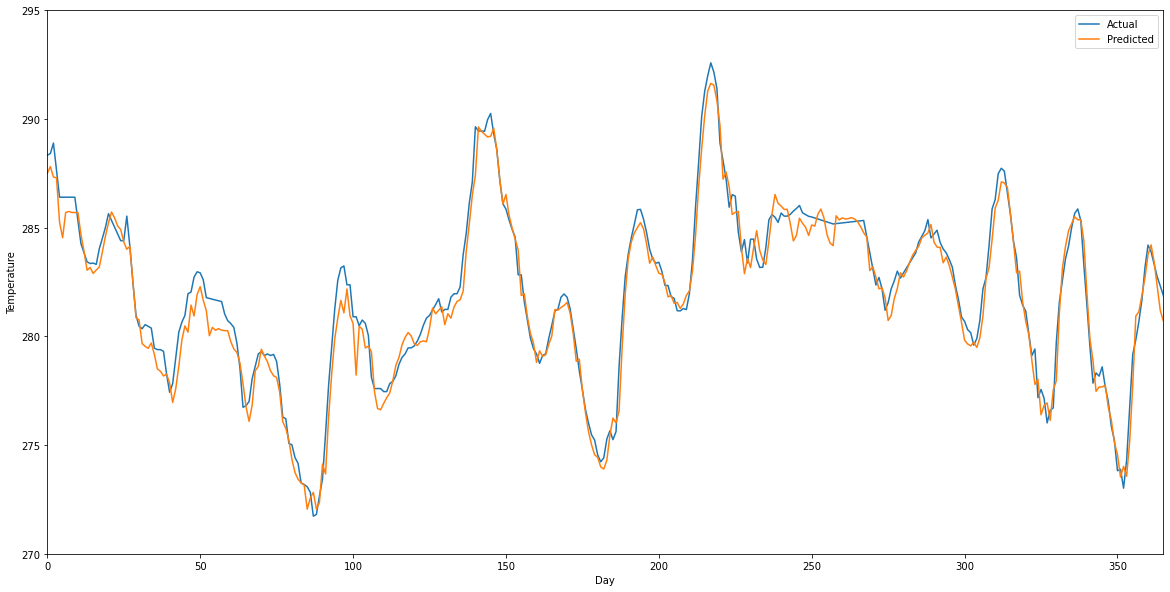

In [17]:
from matplotlib import pyplot as plt
plt.figure(figsize = (20, 10))
plt.plot(y_test_inv, label = 'Actual')
plt.plot(y_pred_inv, label = 'Predicted')
plt.ylabel('Temperature')
plt.xlabel('Day')
plt.xlim([0, 365])
plt.ylim([270, 295])
plt.legend()
plt.show()

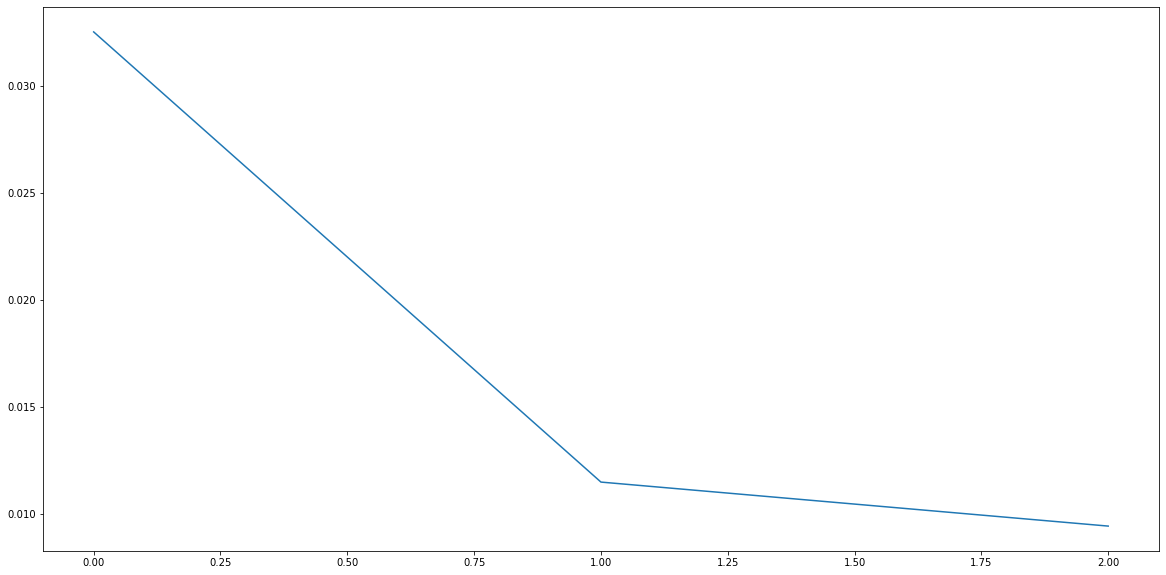

In [19]:
plt.figure(figsize = (20, 10))
plt.plot(history.history['loss'])
plt.show()

In [18]:
print('MSE:', mean_squared_error(y_test_inv, y_pred_inv))
print('R-Squared:', r2_score(y_test_inv, y_pred_inv))
print('RMSE:', math.sqrt(mean_squared_error(y_test_inv, y_pred_inv)))

MSE: 1.651484897076956
R-Squared: 0.9890336822704596
RMSE: 1.2851011232883411
